In [113]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from safe_control_gym.lyapunov.lyapunov import *
from safe_control_gym.lyapunov.utilities import *
from safe_control_gym.experiments.arxiv.utils.gpmpc_plotting_utils import *

In [114]:
dim_grid = 4
grid_constraints = np.array([0.5, 1.5, 1.57, 1.57])
grid_constraints = np.vstack((-1 * grid_constraints, \
                                    grid_constraints)).T
prec = [11, 31, 31, 31]
grids = gridding(dim_grid, grid_constraints, prec)

Grid size: 327701
Discretization constant (tau): 0.0


In [115]:
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
notebook_dir

'/home/mingxuan/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils'

In [116]:
data_folder = '../data/cartpole_data_eff/'
data_folder_path = os.path.join(notebook_dir, data_folder)
data_folder_path

'/home/mingxuan/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils/../data/cartpole_data_eff/'

In [117]:
M = 1400
M = 'M_{}'.format(M)
data_folder_path_M_large = os.path.join(data_folder_path, M)
data_folder_path_M_large

'/home/mingxuan/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils/../data/cartpole_data_eff/M_1400'

In [118]:
data_name_list = os.listdir(data_folder_path_M_large)
files = [filename for filename in data_name_list if filename.startswith('data_epoch_9')]
files

['data_epoch_9_init_315669_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_236973_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_304727_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_159120_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_14211_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_159008_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_179622_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_275583_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_287949_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_68364_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_165110_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_19416_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_179125_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_72309_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz',
 'data_epoch_9_init_18231_M_1.4_m_0.1_l_0.5_prec_11_

In [119]:
init_state_idx = []
for filename in files:
    # split the filename to get the init state index
    init_state_idx.append(int(filename.split('init_')[-1].split('_M')[0]))
sorted_init_state_idx = np.sort(init_state_idx)
print(sorted_init_state_idx)
print('valid init state num:', len(sorted_init_state_idx))

[ 12279  14211  18231  19416  59398  68364  72309  80815 126099 134478
 137180 159008 159120 165110 179125 179622 228778 236973 270838 275583
 287949 300644 304727 315669 321581]
valid init state num: 25


In [120]:
# only load the file with the state index in the sorted_init_state_idx
raw_data = []
for filename in files:
    init_idx = int(filename.split('init_')[-1].split('_M')[0])
    if init_idx in sorted_init_state_idx:
        raw_data.append(np.load(os.path.join(data_folder_path_M_large, filename), allow_pickle=True))
raw_data

[NpzFile '/home/mingxuan/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils/../data/cartpole_data_eff/M_1400/data_epoch_9_init_315669_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz' with keys: train_runs, test_runs, num_epochs, num_train_episodes_per_epoch, num_test_episodes_per_epoch...,
 NpzFile '/home/mingxuan/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils/../data/cartpole_data_eff/M_1400/data_epoch_9_init_236973_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz' with keys: train_runs, test_runs, num_epochs, num_train_episodes_per_epoch, num_test_episodes_per_epoch...,
 NpzFile '/home/mingxuan/Repositories/scg_mx/safe_control_gym/experiments/arxiv/cartpole_performance/utils/../data/cartpole_data_eff/M_1400/data_epoch_9_init_304727_M_1.4_m_0.1_l_0.5_prec_11_31_31_31.npz' with keys: train_runs, test_runs, num_epochs, num_train_episodes_per_epoch, num_test_episodes_per_epoch...,
 NpzFile '/home/mingxuan/Repositories/scg_mx/safe_control_gym

In [121]:
test_runs = [raw_data[i]['test_runs'].item() for i in range(len(raw_data))]
train_runs = [raw_data[i]['train_runs'].item() for i in range(len(raw_data))]

In [122]:
# test_runs
num_points_per_epoch = []  # number of training points
# Compute the number of training points (x-axis for most figures).
num_epochs = len(train_runs[0])
print('num_epochs:', num_epochs)
num_points = 0
num_points_per_epoch.append(num_points)
for epoch in range(1, num_epochs):
    num_train_episodes = len(train_runs[1][epoch])
    for episode in range(num_train_episodes):
        num_points += train_runs[1][epoch][episode]['obs'].shape[0]
    num_points_per_epoch.append(num_points) 
print('num_points_per_epoch:', num_points_per_epoch)

num_epochs: 10
num_points_per_epoch: [0, 338, 613, 873, 1253, 1538, 1918, 2298, 2483, 2863]


mean_cost: [61799.15299355 21401.84455319 19794.45748914 11292.88694477
  8685.01400482  5740.69265641 10042.01954237  3639.45947898
  4901.94859852  3341.01161997]
std_cost: [64059.7927961  43484.06601042 30424.62668833 22743.3422333
 17182.19939996  8661.34786975 26072.29500381  3035.26246771
  7756.01424937  1735.70311494]


(0.0, 202730.69714496212)

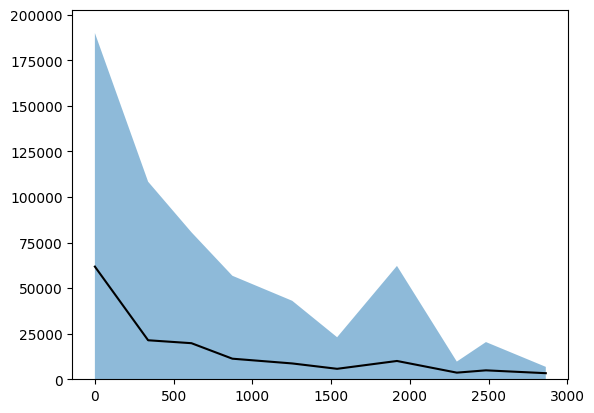

In [123]:
s = 2 # times of std

common_costs = [get_cost(test_runs[i]) for i in range(len(test_runs))]
# num_points_per_epoch
# common_costs

mean_cost = np.mean(common_costs, axis=0)
print('mean_cost:', mean_cost)
std_cost = np.std(common_costs, axis=0)
print('std_cost:', std_cost)
x = num_points_per_epoch
plt.plot(x, mean_cost, 'k-')
plt.fill_between(x, mean_cost - s * std_cost, mean_cost + s * std_cost, alpha=0.5)
# limit the y-axis above 0
plt.ylim(0, None)

In [124]:
# save the mean_cost and std_cost to a file under the notebook_dir
np.savez('mean_std_cost_M_{}.npz'.format(M), mean_cost=mean_cost, std_cost=std_cost, num_points_per_epoch=num_points_per_epoch)